In [5]:
# importing libraries
import numpy as np # For numerical computation
import pandas as pd # Data manipulation
import seaborn as sns # plotting
import scipy.io # reading matlab files in python
from scipy import signal #signal processing
from scipy.fftpack import fft, dct #signal processing
from tqdm import tqdm
from sklearn.preprocessing import MinMaxScaler
import warnings
warnings.filterwarnings('ignore')
from peakDetection.python.PeakDetector import PeakDetector  
from matplotlib import pyplot as plt # For plotting graphs(Visualization)

import os # system-wide functions
# os.listdir('/kaggle/input/BloodPressureDataset')

In [16]:
# ' train ' or 'test'
type = 'train'
train_type = '2'


In [17]:
test = np.load(f"../data/raw/BloodPressureDataset/signal_{type}_bp_masked{train_type}.npy")

print(test.shape)
print()
print(test.shape)

(48475, 3, 1250)

(48475, 3, 1250)


# filter

In [2]:
import numpy as np
test = np.load("../data/raw/BloodPressureDataset/signal_windowed_test.npy")
test.shape

(64916, 3, 1250)

In [3]:
def bandstop_butter(x,low,high):
    fs = 125
    filter = signal.butter(2, Wn=[low,high],btype='bandstop', output='sos',fs=fs)
    return signal.sosfiltfilt(filter, x)

def bandpass_fir(x,low,high):
    fs = 125
    numtaps =255
    filter = signal.firwin(numtaps=numtaps, cutoff=[low,high], fs=fs, pass_zero=False)
    return signal.filtfilt(filter, 1, x)

def lowpass_fir(x,low):
    fs = 125
    numtaps =255
    filter = signal.firwin(numtaps=numtaps, cutoff=low, fs=fs, pass_zero=False)
    return signal.filtfilt(filter, 1, x)

def savgol(x,window,polyorder):
    return signal.savgol_filter(x,window_length=window,polyorder=polyorder)

def chebyshev2(x,order,rs,low,high):
    fs = 125
    filter = signal.cheby2(N=order, Wn=[low,high],rs=rs,btype='bandpass',output='sos',fs=fs)
    return signal.sosfiltfilt(filter,x)

In [5]:
# ecg = test[:,2,:]
ecg = test[2,:]
print(np.where(np.isnan(ecg)))
max_ecg = np.max(ecg)
min_ecg = np.min(ecg)
print(max_ecg,min_ecg)
ecg = (ecg-min_ecg)/(max_ecg-min_ecg)
ecg = ecg *2-1

(array([], dtype=int64),)
1.210654936461388 -0.5004887585532747


In [6]:

band_40 = bandpass_fir(ecg,0.01,40)
band_20 = bandpass_fir(ecg,0.01,20)
print("band done")
low_03 =bandstop_butter(ecg,0.01,0.3)
low_05 = bandstop_butter(ecg,0.01,0.5)
print("low done")
nyq_09 = lowpass_fir(ecg,0.9)
print("nyq done")
savgol_33 = savgol(ecg,5,3) 
savgol_31 = savgol(ecg,5,1)
print("savgol done")
chebyshev_62_20= chebyshev2(ecg,6,2,0.01,20)
print("chebyshev2 done")


band done
low done
nyq done
savgol done
chebyshev2 done


In [20]:
ecg_signals = np.stack([band_40,band_20,low_03,low_05,nyq_09,savgol_33,savgol_31,chebyshev_62_20])
ecg_signals = ecg_signals.transpose(1,0,2)
print(ecg_signals.shape)
np.save(f"../data/raw/BloodPressureDataset/{type}{train_type}_ecg_filtered.npy",ecg_signals)
print(ecg_signals.shape)

(48475, 8, 1250)
(48475, 8, 1250)


In [21]:
del ecg,band_40,band_20,low_03,low_05,nyq_09,savgol_33,savgol_31,chebyshev_62_20

In [9]:
ppg = test[:,0,:]
max_ppg = np.max(ppg)
min_ppg = np.min(ppg)
print(max_ppg,min_ppg)
ppg = (ppg-min_ppg)/(max_ppg-min_ppg)

3.6803519061583576 0.696969696969697


In [10]:

band_20 = bandpass_fir(ppg,0.5,20)
print("band done")
low_03 = bandstop_butter(ppg,0.01,0.3)
print("low done")
savgol_33 = savgol(ppg,5,3)
print("savgol done")
chebyshev_610 = chebyshev2(ppg,6,10,0.5,20)
print("chebyshev2 done")


band done
low done
savgol done
chebyshev2 done


In [11]:
ppg_signals = np.stack([ppg,band_20,low_03,savgol_33,chebyshev_610])
# ppg_signals = ppg_signals.transpose(1,0,2)
print(ppg_signals.shape)

(5, 1250)


In [6]:
ppg_signals = np.stack([band_20,low_03,savgol_33,chebyshev_610])
ppg_signals = ppg_signals.transpose(1,0,2)
print(ppg_signals.shape)

del ppg,band_20,low_03,savgol_33,chebyshev_610

NameError: name 'band_20' is not defined

In [25]:
# ppg_signals = ppg_signals.transpose(1,0,2)
np.save(f"../data/raw/BloodPressureDataset/{type}{train_type}_ppg_filtered.npy",ppg_signals)
print(ppg_signals.shape)

(48475, 4, 1250)


## plot

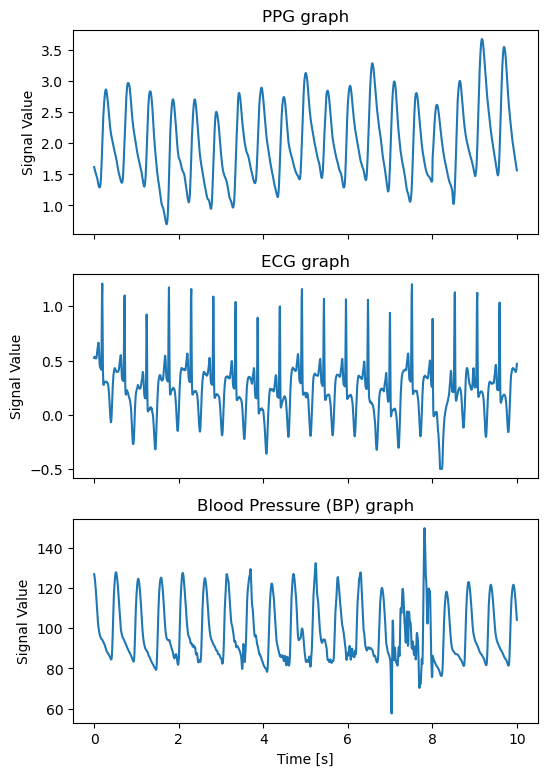

In [38]:
test = np.load("../data/raw/BloodPressureDataset/signal_windowed_test.npy")[0,:,:]
fig, ax = plt.subplots(3,1, figsize=(6,9), sharex=True)
x = np.linspace(0,10,1250)
ax[0].set_title('PPG graph', fontsize=12)
ax[0].set_ylabel('Signal Value')
ax[0].plot(x,test[0])

ax[1].set_title('ECG graph', fontsize=12)
ax[1].set_ylabel('Signal Value')
ax[1].plot(x,test[2])

ax[2].set_title('Blood Pressure (BP) graph', fontsize=12)
ax[2].set_ylabel('Signal Value')
ax[2].set_xlabel('Time [s]')
ax[2].plot(x,test[1])


Text(0.5, 1.0, 'ECG')

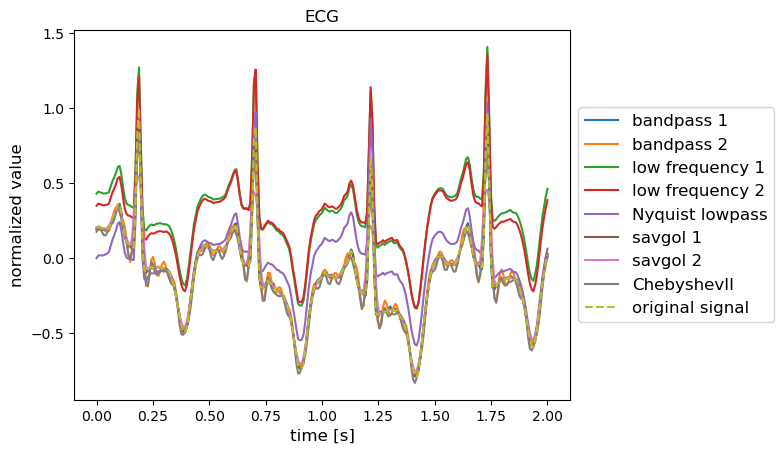

In [29]:
label = ["original signal", "bandpass 1","bandpass 2","low frequency 1","low frequency 2","Nyquist lowpass","savgol 1","savgol 2","ChebyshevII"]
x = np.linspace(0,2,256)
for i in range(ecg_signals.shape[0]-1):
    plt.plot(x,ecg_signals[i+1,:256],label=label[i+1])
plt.plot(x,ecg_signals[0,:256],label=label[0],linestyle='dashed')
plt.legend( loc='center left', bbox_to_anchor=(1., .5),fontsize=12)
plt.xlabel("time [s]",fontsize=12)
plt.ylabel("normalized value",fontsize=12)
plt.title('ECG',fontsize=12)

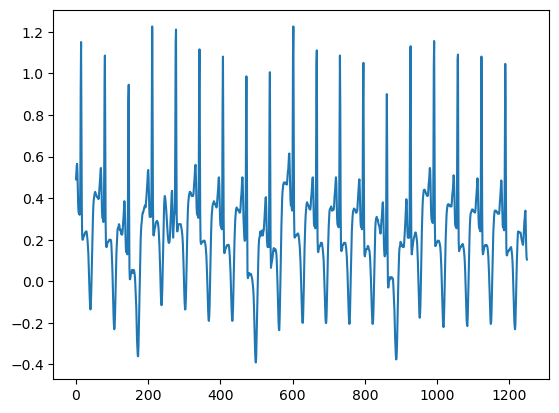

In [29]:
plt.figure()
plt.plot(ecg_signals[0,0])

Text(0.5, 1.0, 'PPG')

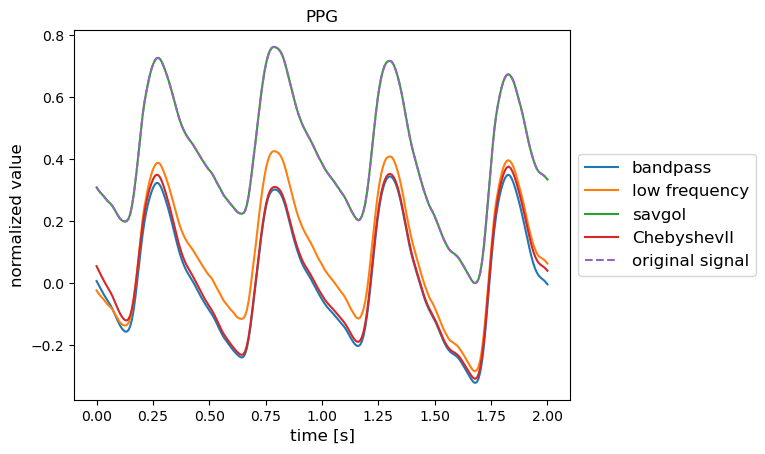

In [32]:
label = ["original signal", "bandpass","low frequency","savgol","ChebyshevII"]
x = np.linspace(0,2,256)
for i in range(ppg_signals.shape[0]-1):
    plt.plot(x,ppg_signals[i+1,:256],label=label[i+1])
plt.plot(x,ppg_signals[0,:256],label=label[0],linestyle='dashed')
plt.legend( loc='center left', bbox_to_anchor=(1., .5),fontsize=12)
plt.xlabel("time [s]",fontsize=12)
plt.ylabel("normalized value",fontsize=12)
plt.title('PPG',fontsize=12)

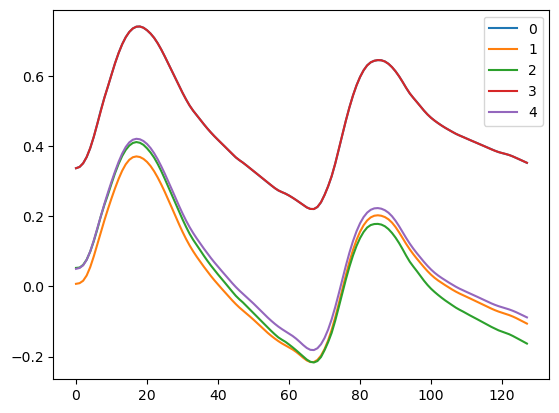

In [63]:
for i in range(ppg_signals.shape[1]):
    plt.plot(ppg_signals[1,i][:128],label=i)
    plt.legend()

# align

## make index

### find peaks

In [30]:
# ' train ' or 'test'
type = 'train'
train_type = '2'


In [31]:
import neurokit2 as nk
test = np.load(f"../data/raw/BloodPressureDataset/signal_{type}_bp_masked{train_type}.npy")

In [32]:
# detector = PeakDetector()
invalid_i = []
peak_i = []
for i in tqdm(range(test.shape[0])):
    ecg = test[i,2]
    ppg = test[i,0]
    _ , ecg_i = nk.ecg_peaks(ecg, sampling_rate=125)
    ecg_i = ecg_i['ECG_R_Peaks']
    ppg_i = nk.ppg_findpeaks(nk.ppg_clean(ppg,sampling_rate=125),sampling_rate=125)
    ppg_i = ppg_i['PPG_Peaks']
    arr = []
    count = 3
    if abs(len(ecg_i)-len(ppg_i)) > 2:
       invalid_i.append(i)
       continue 
    for j in range(1,len(ecg_i)-1):
        if count == 0:
            break
        target_i = ecg_i[j]
        if target_i < 64 or target_i> 1186:
            continue
        if len(arr) > 1:
            if abs(arr[-1][0]-target_i)<128:
                continue 
        distance = np.abs(ppg_i-target_i)
        nearest_i = ppg_i[np.argmin(distance)]
        if nearest_i < 64 or nearest_i> 1186:
            continue
        arr.append([nearest_i,target_i])
        count -=1
    if count != 0:
        invalid_i.append(i)
    else:
        peak_i.append(np.array(arr))



100%|██████████| 48475/48475 [01:27<00:00, 551.20it/s]


save index 

In [33]:
peak_i = np.array(peak_i)
invalid_i = np.array(invalid_i)
full = np.arange(test.shape[0])
print(full.shape,invalid_i.shape)
mask = ~np.in1d(full,invalid_i)
print(mask.shape)
np.savez(f"../data/raw/BloodPressureDataset/align_index_{type}{train_type}.npz", peak_i, mask)
print(peak_i.shape)
print(len(invalid_i))


(48475,) (432,)
(48475,)
(48043, 3, 2)
432


garbage

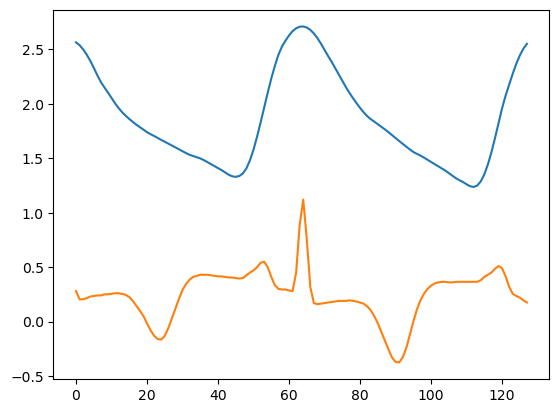

In [99]:
i = 1
n = 0
ppg_test = test[i,0]
ecg_test = test[i,2]
ppg_test = ppg_test[peak_i[i,n,0]-64:peak_i[i,n,0]+64]
ecg_test = ecg_test[peak_i[i,n,1]-64:peak_i[i,n,1]+64]
plt.plot(ppg_test)
plt.plot(ecg_test)

In [134]:
full = np.arange(test.shape[0])
mask = ~np.in1d(full,invalid_i)
test = test[mask]
# print(test.shape,test2.shape)

In [130]:
peak_i[3457]

array([[ 49, 116],
       [195, 190],
       [345, 339]])

In [136]:
ppg_arr = []
ecg_arr = []
bp_arr = []
for i in tqdm(range(peak_i.shape[0])):
    ppg = test[i,0]
    abp = test[i,1]
    ecg = test[i,2]
    ppg_128 = []
    ecg_128 = []
    bp_128 = []
    for n in range(3):
        ppg_128.append(ppg[peak_i[i,n,0]-64:peak_i[i,n,0]+64])
        ecg_128.append(ecg[peak_i[i,n,1]-64:peak_i[i,n,1]+64])
        sbp = np.max(abp[peak_i[i,n,1]-64:peak_i[i,n,1]+64])
        dbp = np.min(abp[peak_i[i,n,1]-64:peak_i[i,n,1]+64])
        bp_128.append(np.array([sbp,dbp]))
    ppg_arr.append(np.array(ppg_128))
    ecg_arr.append(np.array(ecg_128))
    bp_arr.append(np.array(bp_128))
ppg_arr = np.array(ppg_arr)
ecg_arr = np.array(ecg_arr)
bp_arr = np.array(bp_arr)

print(ppg_arr.shape,ecg_arr.shape,bp_arr.shape)

100%|██████████| 31982/31982 [00:01<00:00, 31644.15it/s]

(31982, 3, 128) (31982, 3, 128) (31982, 3, 2)


In [ ]:
np.save()

In [72]:
ecg = test[0,2]
ppg = test[0,0]
print(target.shape)
_ , info = nk.ecg_process(ecg, sampling_rate=125)
info =info['ECG_R_Peaks']
# info = info[np.where((info>64)& (info<1186))]
print(info)
detector = PeakDetector()
detector.clear()
detector.update(ppg)
ppg_i = detector.max_i 
print(detector.max_i)
diff = len(info) - len(ppg_i)




(1250,)
[  80  146  211  276  342  407  472  537  602  667  731  796  861  926
  992 1057 1123 1189]
[  28   94  158  226  290  323  355  420  485  551  616  680  744  810
  875  940 1005 1070 1136 1203]


## format

In [13]:
# ' train ' or 'test'
type = 'train'
train_type = '2'

In [14]:
data= np.load(f'../data/raw/BloodPressureDataset/align_index_{type}{train_type}.npz')
peak_i = data['arr_0']
mask = data['arr_1']

In [15]:
test = np.load(f"../data/raw/BloodPressureDataset/{type}{train_type}_ppg_filtered.npy")
# print(ppg.shape)
test= test[mask]
# print(ppg.shape)
ppg_arr = []
for i in tqdm(range(peak_i.shape[0])):
    ppg = test[i]
    ppg_128 = []
    for n in range(3):
        ppg_128.append(ppg[:,peak_i[i,n,0]-64:peak_i[i,n,0]+64])
    ppg_arr.append(np.array(ppg_128))
ppg_arr = np.array(ppg_arr)
print(ppg_arr.shape)


100%|██████████| 48043/48043 [00:00<00:00, 79255.31it/s]


(48043, 3, 4, 128)


In [16]:
np.save(f"../data/raw/BloodPressureDataset/ppg_128_{type}{train_type}.npy",ppg_arr)
del test, ppg_arr

In [17]:
test = np.load(f"../data/raw/BloodPressureDataset/{type}{train_type}_ecg_filtered.npy")
test = test[mask]
ecg_arr = []
for i in tqdm(range(peak_i.shape[0])):
    ecg = test[i]
    ecg_128 = []
    for n in range(3):
        ecg_128.append(ecg[:,peak_i[i,n,1]-64:peak_i[i,n,1]+64])
    ecg_arr.append(np.array(ecg_128))
ecg_arr = np.array(ecg_arr)
print(ecg_arr.shape)

100%|██████████| 48043/48043 [00:01<00:00, 42515.98it/s]


(48043, 3, 8, 128)


In [18]:
np.save(f"../data/raw/BloodPressureDataset/ecg_128_{type}{train_type}.npy",ecg_arr)
del test, ecg_arr

In [19]:
test = np.load(f"../data/raw/BloodPressureDataset/signal_{type}_bp_masked{train_type}.npy")[:,1]
test = test[mask]
print(test.shape)
bp_arr = []
for i in tqdm(range(peak_i.shape[0])):
    abp = test[i]
    bp_128 = []
    for n in range(3):
        sbp = np.max(abp[peak_i[i,n,1]-64:peak_i[i,n,1]+64])
        dbp = np.min(abp[peak_i[i,n,1]-64:peak_i[i,n,1]+64])
        bp_128.append(np.array([sbp,dbp]))
    bp_arr.append(np.array(bp_128))
bp_arr = np.array(bp_arr)
print(bp_arr.shape)

(48043, 1250)


100%|██████████| 48043/48043 [00:01<00:00, 41062.11it/s]

(48043, 3, 2)


In [20]:
np.save(f"../data/raw/BloodPressureDataset/bp_128_{type}{train_type}.npy",bp_arr)
del test, bp_arr

(9, 128)
(5, 128)


Text(0.5, 1.0, 'ECG')

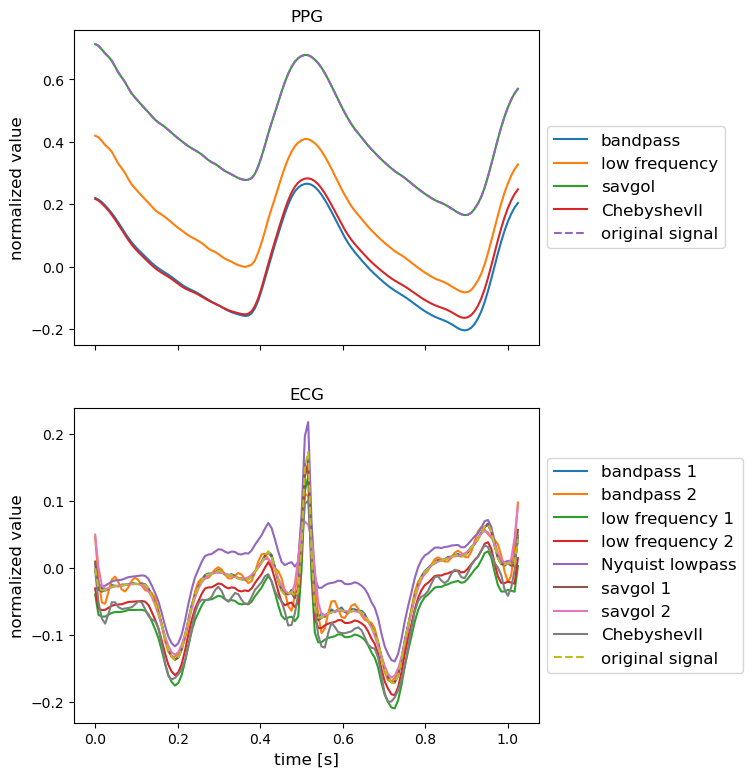

In [14]:
ecg_signals  = np.load(f"../data/raw/BloodPressureDataset/ecg_128_test.npy")[0,0]
print(ecg.shape)
ppg_signals  = np.load(f"../data/raw/BloodPressureDataset/ppg_128_test.npy")[0,0]
print(ppg.shape)

label = ["original signal", "bandpass","low frequency","savgol","ChebyshevII"]
fig, ax = plt.subplots(2,1, figsize=(6,9), sharex=True)
x = np.linspace(0,1.024,128)
ax[0].set_title('PPG', fontsize=12)
ax[0].set_ylabel('Signal Value')
for i in range(ppg_signals.shape[0]-1):
    ax[0].plot(x,ppg_signals[i+1,:256],label=label[i+1])
ax[0].set_ylabel("normalized value",fontsize=12)
ax[0].plot(x,ppg_signals[0,:256],label=label[0],linestyle='dashed')
ax[0].legend( loc='center left', bbox_to_anchor=(1., .5),fontsize=12)

ax[1].set_title('ECG graph', fontsize=12)
ax[1].set_ylabel('Signal Value')
label = ["original signal", "bandpass 1","bandpass 2","low frequency 1","low frequency 2","Nyquist lowpass","savgol 1","savgol 2","ChebyshevII"]
for i in range(ecg_signals.shape[0]-1):
    ax[1].plot(x,ecg_signals[i+1,:256],label=label[i+1])
ax[1].plot(x,ecg_signals[0,:256],label=label[0],linestyle='dashed')
ax[1].legend( loc='center left', bbox_to_anchor=(1., .5),fontsize=12)
ax[1].set_xlabel("time [s]",fontsize=12)
ax[1].set_ylabel("normalized value",fontsize=12)
ax[1].set_title('ECG',fontsize=12)


In [2]:
import numpy as np
train1_ppg = np.load("../data/raw/BloodPressureDataset/ppg_128_train1.npy")
train1_ecg = np.load("../data/raw/BloodPressureDataset/ecg_128_train1.npy")
train1_bp = np.load("../data/raw/BloodPressureDataset/bp_128_train1.npy")
train2_ppg = np.load("../data/raw/BloodPressureDataset/ppg_128_train2.npy")
train2_ecg = np.load("../data/raw/BloodPressureDataset/ecg_128_train2.npy")
train2_bp = np.load("../data/raw/BloodPressureDataset/bp_128_train2.npy")

ppg = np.vstack([train1_ppg,train2_ppg])
ecg = np.vstack([train1_ecg,train2_ecg])
bp = np.vstack([train1_bp,train2_bp])
print(ppg.shape)
np.savez("../data/processed/train_0731.npz",PPG=ppg,ECG=ecg,BP=bp)

(97662, 3, 4, 128)


In [1]:
import numpy as np
ppg = np.load("../data/raw/BloodPressureDataset/ppg_128_test.npy")
ecg = np.load("../data/raw/BloodPressureDataset/ecg_128_test.npy")
bp = np.load("../data/raw/BloodPressureDataset/bp_128_test.npy")
np.savez("../data/processed/test_0731.npz",PPG=ppg,ECG=ecg,BP=bp)